# Study case: MNIST hand-written digits dataset

##### License: Apache 2.0


This notebook shows how to use topological data analysis to generate features for classifying digits.

The first step consists in importing the *giotto* library.

In [1]:
from giotto.images import ImageBinarizer, ImageInverter, ImageToPointCloud, HeightFiltration, DilationFiltration, RadialFiltration, ErosionFiltration, SignedDistanceFiltration, DensityFiltration
from giotto.homology import VietorisRipsPersistence, CubicalPersistence
from giotto.diagram import DiagramStacker, DiagramDistance, DiagramAmplitude, DiagramScaler, PersistenceEntropy, BettiCurve, PersistenceLandscape, HeatKernel

from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion, make_union
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone

import numpy as np
import pandas as pd
import random
import gzip
import pickle as pkl
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline

## Loading the MNIST dataset

In [2]:
# Read the data
((X, y), (X_valid, y_valid), _) = pkl.load(gzip.open('mnist.pkl.gz', 'rb'), encoding='latin-1')

X = X.reshape(-1, 28, 28)

print(X.shape, y.shape)
print(np.min(X), np.max(X))

(50000, 28, 28) (50000,)
0.0 0.99609375


In [3]:
# Set up the data
n_train, n_test = 40000, 10000

X_train = X[:n_train]
y_train = y[:n_train]
X_test = X[n_train:n_train+n_test]
y_test = y[n_train:n_train+n_test]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(40, 28, 28) (40,) (10, 28, 28) (10,)


In [4]:
direction_list = [ [1, 0], [1, 1], [0, 1], [-1, 1], [-1, 0], [-1, -1], [0, -1], [1, -1] ] 
center_list = [ [13, 6], [6, 13], [13, 13], [20, 13], [13, 20], [6, 6], [6, 20], [20, 6], [20, 20] ]
n_iterations_erosion_list = [6, 10]
n_iterations_dilation_list = [6, 10]
n_iterations_signed_list = [6, 10]
n_neighbors_list = [2, 4]

filtration_list = \
 [HeightFiltration(direction=direction, normalize=False) 
   for direction in direction_list] + \
 [RadialFiltration(center=center, normalize=False) 
   for center in center_list] + \
 [ErosionFiltration(n_iterations=n_iterations, normalize=False) 
   for n_iterations in n_iterations_erosion_list] + \
 [DilationFiltration(n_iterations=n_iterations, normalize=False) 
   for n_iterations in n_iterations_dilation_list] + \
 [SignedDistanceFiltration(n_iterations=n_iterations, normalize=False) 
   for n_iterations in n_iterations_signed_list] + \
 [DensityFiltration(n_neighbors=n_neighbors, normalize=False)
   for n_neighbors in n_neighbors_list] + \
 [None]

binarizer = ImageBinarizer(threshold=0.4)
point = ImageToPointCloud()
cubical = CubicalPersistence(homology_dimensions=[0, 1])
rips = VietorisRipsPersistence(homology_dimensions=[0, 1])
scaler = DiagramScaler(metric='bottleneck')

grayscale_steps = [[cubical, scaler]]
filtration_steps = [[binarizer, filtration, cubical, scaler] for filtration in filtration_list]
rips_steps = [[binarizer, point, rips, scaler]]

image_steps = grayscale_steps + filtration_steps + rips_steps

metric_list = [ 
   {'metric': 'bottleneck', 'metric_params': {'p': np.inf}},
   {'metric': 'wasserstein', 'metric_params': {'p': 1}},
   {'metric': 'wasserstein', 'metric_params': {'p': 2}},
   {'metric': 'landscape', 'metric_params': {'p': 1, 'n_layers': 1, 'n_values': 100}},
   {'metric': 'landscape', 'metric_params': {'p': 1, 'n_layers': 2, 'n_values': 100}},
   {'metric': 'landscape', 'metric_params': {'p': 2, 'n_layers': 1, 'n_values': 100}},
   {'metric': 'landscape', 'metric_params': {'p': 2, 'n_layers': 2, 'n_values': 100}},
   {'metric': 'betti', 'metric_params': {'p': 1, 'n_values': 100}},
   {'metric': 'betti', 'metric_params': {'p': 2, 'n_values': 100}},
   {'metric': 'heat', 'metric_params': {'p': 1, 'sigma': 1.6, 'n_values': 100}},
   {'metric': 'heat', 'metric_params': {'p': 1, 'sigma': 3.2, 'n_values': 100}},
   {'metric': 'heat', 'metric_params': {'p': 2, 'sigma': 1.6, 'n_values': 100}},
   {'metric': 'heat', 'metric_params': {'p': 2, 'sigma': 3.2, 'n_values': 100}}
]

entropy_steps = [steps + [PersistenceEntropy()] for steps in image_steps]
amplitude_steps = [steps+[DiagramAmplitude(**metric, order=None)] for steps in image_steps for metric in metric_list]

all_steps = entropy_steps + amplitude_steps
feature_union = make_union(*[make_pipeline(*steps) for steps in all_steps], n_jobs=-1)

In [5]:
X_train_tda = feature_union.fit_transform(X_train, y_train)
pkl.dump(X_train_tda, open('X_train_tda.pkl', 'wb'))

/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:49: RuntimeWarning: invalid value encountered in true_divide
  X_normalized = X_lifespan / np.sum(X_lifespan, axis=1).reshape(-1, 1)
/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:51: RuntimeWarning: divide by zero encountered in log
  X_normalized * np.log(X_normalized)), axis=1).reshape(-1, 1)
/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:51: RuntimeWarning: invalid value encountered in multiply
  X_normalized * np.log(X_normalized)), axis=1).reshape(-1, 1)
/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:49: RuntimeWarning: invalid value encountered in true_divide
  X_normalized = X_lifespan / np.sum(X_lifespan, axis=1).reshape(-1, 1)
/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:51: RuntimeWarning: divide by zero encountered in log
  X_normalized * np.log(X_normalized)), axis=1).reshape(-1, 1)
/Users/guillaumetau

In [6]:
X_test_tda = feature_union.transform(X_test)
pkl.dump(X_test_tda, open('X_test_tda.pkl', 'wb'))

/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:49: RuntimeWarning: invalid value encountered in true_divide
  X_normalized = X_lifespan / np.sum(X_lifespan, axis=1).reshape(-1, 1)
/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:51: RuntimeWarning: divide by zero encountered in log
  X_normalized * np.log(X_normalized)), axis=1).reshape(-1, 1)
/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:51: RuntimeWarning: invalid value encountered in multiply
  X_normalized * np.log(X_normalized)), axis=1).reshape(-1, 1)
/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:51: RuntimeWarning: divide by zero encountered in log
  X_normalized * np.log(X_normalized)), axis=1).reshape(-1, 1)
/Users/guillaumetauzin/software/giotto-learn/giotto/diagram/features.py:51: RuntimeWarning: invalid value encountered in multiply
  X_normalized * np.log(X_normalized)), axis=1).reshape(-1, 1)


In [7]:
print(X_train_tda.shape)

(40, 784)


In [8]:
classifier = RandomForestClassifier(n_estimators=10000, n_jobs=-1)
classifier.fit(X_train_tda, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10000,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [9]:
y_train_predict = classifier.predict(X_train_tda)
pkl.dump(y_train_predict, open('y_train_predict_tda.pkl', 'wb'))

In [10]:
y_test_predict = classifier.predict(X_test_tda)
pkl.dump(y_test_predict, open('y_test_predict_tda.pkl', 'wb'))

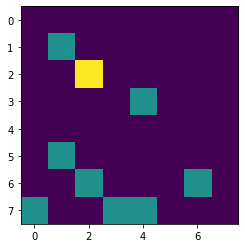

In [11]:
confusion = confusion_matrix(y_test, y_test_predict)
plt.imshow(confusion)
plt.show()

In [12]:
importance = -classifier.feature_importances_
importance_indices = np.argsort(importance)

In [13]:
X_train_importance = X_train_tda[:, importance_indices]
print(X_train_importance.shape)

(40, 784)


/Users/guillaumetauzin/anaconda3/envs/giotto/lib/python3.6/site-packages/numpy/lib/function_base.py:2534: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/guillaumetauzin/anaconda3/envs/giotto/lib/python3.6/site-packages/numpy/lib/function_base.py:2535: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


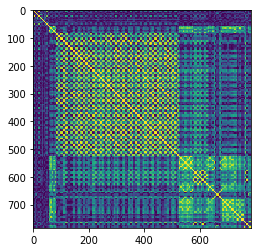

In [14]:
correlation = np.abs(np.corrcoef(X_train_tda.T))
plt.imshow(correlation)
plt.show()

In [15]:
def select_features(correlation_, importance_indices_, threshold_):
    decorrelated_index = importance_indices_[:1]

    for index in importance_indices_[1:]:
        if np.sum(correlation_[decorrelated_index, index] > threshold_) == 0:
            decorrelated_index = np.append(decorrelated_index, [index])
    return decorrelated_index

In [16]:
def run_cv_scores(thresholds_list_, n_features_list_, correlation_, importance_indices_, postfix, n_folds=3):
    for threshold_ in thresholds_list_:
        print('threshold: ', threshold_)
        decorrelated_feature_index = select_features(correlation_, importance_indices_, threshold_=threshold_)
        n_features_max = decorrelated_feature_index.shape[0]
        print('Number of decorrelated features: ', n_features_max)
        n_features_list = sorted(list(set([n_features if n_features <= n_features_max else n_features_max
                               for n_features in n_features_list_])))
        print('n_features_list: ', n_features_list)

        cv_scores = {}
        cv = KFold(n_folds)
        for n_features in n_features_list:
            X_train_n_features = X_train_tda[:, decorrelated_feature_index[:n_features]]
            print('X_train shape: ', X_train_n_features.shape)
            cv_scores[n_features] = cross_val_score(classifier, 
                                                    X_train_n_features, 
                                                    y_train, cv=cv)
            print('cv scores for', postfix, ': ', n_features, cv_scores[n_features])
        pkl.dump(cv_scores, open('cv_scores_'+str(threshold_)+'_'+postfix+'.pkl', 'wb'))

In [17]:
thresholds_list = [0.8, 0.9, 0.95, 1.0]
n_features_list = [4, 8, 28, 42, 56, 112, 178, 244, 392, 784]
run_cv_scores(thresholds_list, n_features_list, correlation, importance_indices, 'tda')

threshold:  0.8
Number of decorrelated features:  62
n_features_list:  [4, 8, 28, 42, 56, 62]
X_train shape:  (40, 4)


/Users/guillaumetauzin/anaconda3/envs/giotto/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


cv scores for tda :  4 [0.64285714 0.46153846 0.38461538]
X_train shape:  (40, 8)
cv scores for tda :  8 [0.64285714 0.46153846 0.38461538]
X_train shape:  (40, 28)
cv scores for tda :  28 [0.57142857 0.23076923 0.30769231]
X_train shape:  (40, 42)
cv scores for tda :  42 [0.5        0.23076923 0.15384615]
X_train shape:  (40, 56)
cv scores for tda :  56 [0.5        0.23076923 0.23076923]
X_train shape:  (40, 62)
cv scores for tda :  62 [0.42857143 0.23076923 0.15384615]
threshold:  0.9
Number of decorrelated features:  102
n_features_list:  [4, 8, 28, 42, 56, 102]
X_train shape:  (40, 4)


/Users/guillaumetauzin/anaconda3/envs/giotto/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


cv scores for tda :  4 [0.64285714 0.46153846 0.38461538]
X_train shape:  (40, 8)
cv scores for tda :  8 [0.64285714 0.46153846 0.38461538]
X_train shape:  (40, 28)
cv scores for tda :  28 [0.64285714 0.23076923 0.23076923]
X_train shape:  (40, 42)
cv scores for tda :  42 [0.5        0.23076923 0.15384615]
X_train shape:  (40, 56)
cv scores for tda :  56 [0.42857143 0.23076923 0.15384615]
X_train shape:  (40, 102)
cv scores for tda :  102 [0.42857143 0.23076923 0.07692308]
threshold:  0.95
Number of decorrelated features:  155
n_features_list:  [4, 8, 28, 42, 56, 112, 155]
X_train shape:  (40, 4)


/Users/guillaumetauzin/anaconda3/envs/giotto/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """


cv scores for tda :  4 [0.64285714 0.46153846 0.38461538]
X_train shape:  (40, 8)
cv scores for tda :  8 [0.64285714 0.46153846 0.38461538]
X_train shape:  (40, 28)
cv scores for tda :  28 [0.64285714 0.23076923 0.23076923]
X_train shape:  (40, 42)
cv scores for tda :  42 [0.5        0.23076923 0.15384615]
X_train shape:  (40, 56)
cv scores for tda :  56 [0.42857143 0.23076923 0.15384615]
X_train shape:  (40, 112)


KeyboardInterrupt: 